# I-9 Assistant using Agentic Corrective RAG System

This assistant helps business vet an employee submission of an I-9 and provides next steps if the form is incomplete.



The implementation is based on [A Comprehensive Guide to Building Agentic RAG Systems with LangGraph](https://www.analyticsvidhya.com/blog/2024/07/building-agentic-rag-systems-with-langgraph) by [Dipanjan (DJ) Sarkar](https://www.analyticsvidhya.com/blog/author/djsarkar/).

The idea would be to implement the workflow taking inspiration from the [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884) research paper.

## Business problem:

The I-9 (Employment Eligibility Verification) form serves several critical business needs:

Legal Compliance
- Required by federal law for every new hire in the U.S.
- Employers must verify both identity and employment eligibility within 3 business days of hire
- Failure to properly complete and maintain I-9s can result in significant fines ($234-$2,332 per violation as of 2024) and potential criminal penalties

Risk Management
- Protects against hiring unauthorized workers, which can lead to:
  - Department of Labor investigations
  - Immigration and Customs Enforcement (ICE) audits
  - Loss of business licenses in some jurisdictions
  - Reputational damage
- Creates a clear audit trail of employment eligibility verification

Workplace Security
- Helps ensure all employees are who they claim to be
- Establishes a consistent verification process across all new hires
- Supports overall workplace safety and security measures

Business Operations
- Required for payroll and tax documentation
- Often needed for government contracts and certifications
- May be necessary for business loans or corporate transactions
- Essential for maintaining clean corporate records


## Technical challenges

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers

The idea is to couple a RAG system with a few checks in place and perform web searches if there is a lack of relevant context documents to the given user query as follows:

![](https://i.imgur.com/uhybMhT.png)


## Implementation

This implementation is s complete Multi-Agent System using LangGraph. There will be one Supervisor Agent which can communicate with other specialized agents. Each agent has their own set of tools, mirroring how we at Futuresmart AI structure enterprise-grade AI solutions.

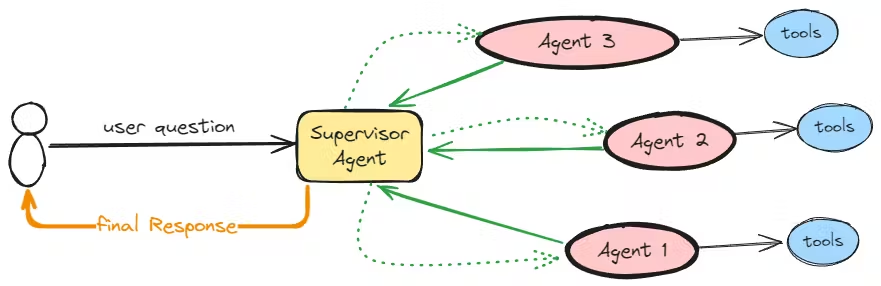

## Install OpenAI, Tavily, and LangChain dependencies

In [ ]:
!pip install -U langgraph

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers docling

# !pip install tensorflow>=2.17.1 langchain>=0.2.0 langchain-openai>=0.1.7 langchain-community>=0.2.0 langgraph>=0.1.1 langchain-chroma>=0.1.2 tokenizer docling langchain_cohere rank_bm25 rank-llm>=0.12.8
# !pip install python-dotenv
# !pip install -qU pypdf

In [2]:
import os

# for Colab users
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
HF_TOKEN = userdata.get('HF_TOKEN')
# CO_API_KEY = userdata.get('CO_API_KEY')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['HF_TOKEN'] = HF_TOKEN
# os.environ['CO_API_KEY'] = CO_API_KEY

from google.colab import drive
drive.mount('/content/drive')
'''
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']
HF_TOKEN = os.environ['HF_TOKEN']
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


"\nfrom dotenv import load_dotenv\nload_dotenv()  # take environment variables from .env.\nOPENAI_API_KEY = os.environ['OPENAI_API_KEY']\nTAVILY_API_KEY = os.environ['TAVILY_API_KEY']\nHF_TOKEN = os.environ['HF_TOKEN']\n"

Set up a logger

In [3]:
import logging

# Configure the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## Build a Search Index for Instructions

For the creation of the vector store, a paragraph-based chunking approach is implemented using Docling and LangChain, and the vector database is built with ChromaDB.

First, load the manual that has been copied to `data/i9_instructions.pdf`. (The original can be found at https://www.uscis.gov/sites/default/files/document/forms/i-9instr.pdf )

In [4]:
file_path = (
    "/content/drive/My Drive/Colab Notebooks/data/i-9instr.pdf"
)

In [5]:
'''
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)
    ## TODO: add metadata about the document being loaded
'''

'\nfrom langchain_community.document_loaders import PyPDFLoader\n\nloader = PyPDFLoader(file_path)\npages = []\nasync for page in loader.alazy_load():\n    pages.append(page)\n    ## TODO: add metadata about the document being loaded\n'

**Reference documentation** [Docling](https://ds4sd.github.io/docling/)

*Features*
- 🗂️ Reads popular document formats (PDF, DOCX, PPTX, XLSX, Images, HTML, AsciiDoc & Markdown) and exports to HTML, Markdown and JSON (with embedded and referenced images)
- 📑 Advanced PDF document understanding incl. page layout, reading order & table structures
- 🧩 Unified, expressive DoclingDocument representation format
- 🤖 Plug-and-play integrations incl. LangChain, LlamaIndex, Crew AI & Haystack for agentic AI
- 🔍 OCR support for scanned PDFs
- 💻 Simple and convenient CLI

**Alternatives**

API Reference [PyPDFLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyPDFLoader.html)
If you want to load a folder, see [Langchain Pdf Loader Multiple Files](https://www.restack.io/docs/langchain-knowledge-pdf-loader-multiple-files-cat-ai)

In [6]:
from docling.document_converter import DocumentConverter

logger.info("Starting document processing.")
converter = DocumentConverter()
markdown_document = converter.convert(file_path).document.export_to_markdown()

In [7]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2")
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on)
docs_list = markdown_splitter.split_text(markdown_document)
docs_list

[Document(metadata={}, page_content='<!-- image -->'),
 Document(metadata={'Header 2': 'Department of Homeland Security'}, page_content="U.S. Citizenship and Immigration Services  \nUSCIS Form I-9  \nOMB No. 1615-0047 Expires 05/31/2027  \nAnti-Discrimination Notice: Employers must allow all employees to choose which acceptable documentation to present for Form I-9.  Employers cannot ask employees for documentation to verify information entered in Section 1 , or specify which acceptable documentation employees must present for Section 2 or Supplement B, Reverification and Rehire . Employees do NOT need to prove their citizenship, immigration status, or national origin when establishing their employment authorization for Form I-9 or E-Verify.  Requesting such proof or any specific document from employees based on their citizenship, immigration status, or national origin, may be illegal.  Similarly, discriminating against employees in hiring, firing, recruitment, or referral for a fee, b

In [8]:
print(f"Number of Document objects: {len(docs_list)}")

Number of Document objects: 29


Based on the headers and using MarkdownHeaderTextSplitter, the output text was subsequently split into chunks, resulting in a list of 29 Document objects

## Vector store

The following code uses [LangChain Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)

If you want to use a in memory vector store, see [https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html]


In [9]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings()

vectorstore_from_documents = Chroma.from_documents(
    documents=docs_list,
    collection_name="rag-chroma-i9-v1",
    embedding=embd,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory='db_vector'
)

In [10]:
similarity_threshold_retriever = vectorstore_from_documents.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 3,
                                                                       "score_threshold": 0.3})

Smoke test

In [11]:
query = "what is first step for an employee submitting an i-9?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'Header 2': 'EMPLOYEES'}, page_content='Employees must complete and sign Section 1 of Form I-9 no later than the first day of employment (i.e., the date the employee begins performing labor or services in the United States in return for wages or other remuneration).  Employees may complete Section 1 before the first day of employment, but cannot complete the form before acceptance of an offer of employment.'),
 Document(metadata={'Header 2': 'EMPLOYEES'}, page_content='Employees must complete and sign Section 1 of Form I-9 no later than the first day of employment (i.e., the date the employee begins performing labor or services in the United States in return for wages or other remuneration).  Employees may complete Section 1 before the first day of employment, but cannot complete the form before acceptance of an offer of employment.'),
 Document(metadata={'Header 2': 'EMPLOYEES'}, page_content='Employees must complete and sign Section 1 of Form I-9 no later than the

## Create LLM object

In [12]:
from langchain_openai import ChatOpenAI

# LLM for grading
llm = ChatOpenAI(model="gpt-4o", temperature=0)


# Create tools

We will create these agents:

- Agent to grade any retrieved document
- One agent can do web research with a search engine tool.
- One agent can retrieve documents and answers based on that.
- Agent to check hallicunations.

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## Create query retrieval grader

In [14]:
# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1363: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


### Test

In [15]:
query = "what is an I-9?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

Employers and employees must complete their respective sections of Form I-9.  The form is used to document verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 6, 1986, to work in the United States.  In the Commonwealth of the Northern Mariana Islands (CNMI), employers must complete Form I-9 to document the verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 27, 2011.
GRADE: binary_score='yes'

Employers and employees must complete their respective sections of Form I-9.  The form is used to document verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 6, 1986, to work in the United States.  In the Commonwealth of the Northern Mariana Islands (CNMI), employers must complete Form I-9 to document the verification of the identity and employment au

In [16]:
query = "what is a 1099?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

Employers and employees must complete their respective sections of Form I-9.  The form is used to document verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 6, 1986, to work in the United States.  In the Commonwealth of the Northern Mariana Islands (CNMI), employers must complete Form I-9 to document the verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 27, 2011.
GRADE: binary_score='no'

Employers and employees must complete their respective sections of Form I-9.  The form is used to document verification of the identity and employment authorization of each new employee (both U.S. citizen and noncitizen) hired after November 6, 1986, to work in the United States.  In the Commonwealth of the Northern Mariana Islands (CNMI), employers must complete Form I-9 to document the verification of the identity and employment aut

## Create the QA RAG Chain

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)
# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [18]:
query = "what is the first step for an employee to prepare an I-9?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

The first step for an employee to prepare an I-9 is to complete and sign Section 1 of Form I-9. This must be done no later than the first day of employment, which is the date the employee begins performing labor or services in the United States in return for wages or other remuneration. While employees can complete Section 1 before the first day of employment, they cannot do so before accepting an offer of employment.


In [19]:
query = "what is a 1099?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

I don't know the answer.


## Create the Query Rephraser

A query rephraser which will use an LLM to rephrase the input user query into a better version which is optimized for web search

In [20]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

### Test

In [21]:
query = "what is a 1099"
question_rewriter.invoke({"question": query})

'What is the purpose and use of IRS Form 1099?'

### Test query rephraser

In [22]:
query = "what is the first step to filling out an I-9?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

The first step to filling out an I-9 form is for the employee to complete and sign Section 1. This must be done no later than the first day of employment, which is the date the employee begins performing labor or services in the United States in return for wages or other remuneration. While employees can complete Section 1 before their first day of employment, they cannot do so before accepting an offer of employment.


## Create the Web Search Tool

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

# Build Agentic RAG Components

## Graph State

Used to store and represent the state of the agent graph as we traverse through various nodes

In [24]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve from Vector DB

Gets relevant context documents from the vector database

In [25]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

## Grade documents

This will be used to determine whether the retrieved documents are relevant to the question by using an LLM Grader

Sets the `web_search_needed` flag as `Yes` if at least one document is not contextually relevant and sets it as `No` if all documents are contextually relevant to the given user query

In [26]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

### Rewrite query

Rewrites the input query to produce a better question optimized for web search using an LLM

In [27]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web search

Searchs the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [28]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Generate the answer

Standard LLM Response generation from query and context documents in a RAG system

In [29]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

## Decide to generate

This is a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [30]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

## Build the Agent Graph

Use LangGraph and build the agent as a graph

In [31]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

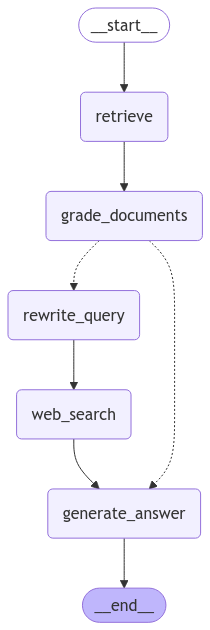

In [32]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

#### Test

In [33]:
query = "what is the the first step in completing the I-9?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [34]:
display(Markdown(response['generation']))

The first step in completing the I-9 form is for employees to complete and sign Section 1. This must be done no later than the first day of employment, which is the date the employee begins performing labor or services in the United States in return for wages or other remuneration. Employees have the option to complete Section 1 before the first day of employment, but they cannot complete the form before accepting an offer of employment.

In [35]:
query = "what is a 1099?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [36]:
display(Markdown(response['generation']))

The IRS Form 1099 serves a critical role in U.S. tax reporting by ensuring financial transparency between payers and recipients of various income streams. It is a key component of the IRS's information return matching program, which automates tax reporting and the issuance of tax notices to collect additional taxes. The form allows the IRS to match data against tax returns easily, as each Form 1099 is linked to an individual's Social Security number. This enables the IRS to issue a tax bill if a taxpayer fails to report income documented on a Form 1099.

Form 1099 is used to report a wide range of income types, including freelance payments, investment income, retirement account distributions, Social Security benefits, government payments, and withdrawals from 529 college savings plans and health savings accounts. It also reports interest income received, any federal income taxes withheld, and tax-exempt interest, among other information. Taxpayers are generally required to report this income on their tax returns, and failing to do so can result in receiving a computer-generated letter from the IRS billing them for the taxes owed.

In summary, the purpose of IRS Form 1099 is to document and report various types of income to ensure accurate tax reporting and compliance, thereby facilitating the IRS's ability to verify and collect taxes owed.

# UI

In [37]:
!pip install --upgrade gradio

In [46]:
import gradio as gr

# Define your custom function
def my_function(input_text):
    response = agentic_rag.invoke({"question": input_text})
    return response['generation']

# Define the Gradio interface
iface = gr.Interface(
    fn=my_function,  # Your function to call
    inputs=gr.Textbox(label="I can help you with your I-9"),  # Input textbox
    outputs=gr.Textbox(label="Output Text")  # Output textbox
)

# Launch the interface
iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fa5823871c57177367.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://aa716f65b682db5483.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://3812fd2fb4c9b15e30.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://521c782b58b7fbd84d.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://d6bf16983cd9bf7840.gradio.live
Killing tunnel 127.0.0.1:7864 <> https://1e26ffae9dc5012d68.gradio.live
Killing tunnel 127.0.0.1:7865 <> https://f4ffec9f84e459e72b.gradio.live
Killing tunnel 127.0.0.1:7866 <> https://cb34184f384debb7b2.gradio.live
Killing tunnel 127.0.0.1:7867 <> https://47715ad3392a9b6483.gradio.live
Killing tunnel 127.0.0.1:7868 <> https://fa5823871c57177367.gradio.live
